# Comparison of velocity and streamline results

Here, you will learn how to use CSP4ML to calculate RNA velocities, visualize the streamlines in two dimensions, and pick genes of interest to view their velocities. In addition, this tutorial will show the comparison of the results of CSP4ML with the dynamo twostep method.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dynamo as dyn
import numpy as np
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

## Load the data

The analysis is based on the cell cycle dataset. Here **rpe1_kinetics_without_spliced** contains only new and total RNA data, and **rpe1_kinetics** contains unspliced unlabeled (uu), unspliced labeled (ul), spliced unlabeled (su) and spliced labeled (sl) RNA data. 

To run velocity analysis on your own data, read your fileto an AnnData object with adata = dyn.read('file name').

In [2]:
filename = './data/rpe1.h5ad'
rpe1 = dyn.read(filename)

dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time / 60  # convert minutes to hours

Cell_cycle_relativePos = rpe1_kinetics.obs['Cell_cycle_relativePos'].values

rpe1_kinetics_without_spliced = rpe1_kinetics.copy()

rpe1_kinetics_without_spliced.layers['new'], rpe1_kinetics_without_spliced.layers['total'] = rpe1_kinetics_without_spliced.layers['ul'] + rpe1_kinetics_without_spliced.layers['sl'], \
                                                             rpe1_kinetics_without_spliced.layers['su'] + rpe1_kinetics_without_spliced.layers['sl'] + \
                                                             rpe1_kinetics_without_spliced.layers['uu'] + rpe1_kinetics_without_spliced.layers['ul']

del rpe1_kinetics_without_spliced.layers['uu'], rpe1_kinetics_without_spliced.layers['ul'], rpe1_kinetics_without_spliced.layers['su'], rpe1_kinetics_without_spliced.layers['sl']

del rpe1

Functions for calculating the consistency score and correctness score of each cell's velocity.

In [3]:
def correct_statistics(X, V):
    """Count whether the velocity of each cell matches its relative position"""
    correct = np.zeros_like(Cell_cycle_relativePos)
    
    X_plus_V = X + V

    nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean').fit(X)
    indices = nbrs.kneighbors(X_plus_V, return_distance=False)

    cell_number = X.shape[0]
    for i in range(cell_number):
        if (Cell_cycle_relativePos[indices[i]] - Cell_cycle_relativePos[i]) > 0:
            correct[i] = 1
        else:
            correct[i] = 0
            
    return correct

def consistency_statistics(adata, X, V):
    """Count the consistency of the velocity of each cell with the velocity of the neighboring cells."""
    dyn.tl.cell_wise_confidence(adata, X_data=X, V_data=V, method='correlation')
    cell_wise_confidence = np.array(adata.obs['correlation_velocity_confidence'])
    
    return cell_wise_confidence

##  Total RNA velocity results based on data without spliced mRNA information

We used dynamo twostep, CSP and CSZIP methods to calculate total RNA velocity and visualize the streamlines in two dimensions, respectively. 

In addition, we selected typical genes DCBLD2 and HIPK2 to illustrate the superiority of CSP4ML compared to the dynamo method. 

Finally, we quantitatively compared the RNA velocity calculation results of different methods by consistency score and correctness score.

### Dynamo twostep method

Set **est_method='twostep'** to use dynamo twostep method:

In [4]:
rpe1_kinetics_without_spliced_dynamo = rpe1_kinetics_without_spliced.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_without_spliced_dynamo,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=True,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='twostep',
                       )

rpe1_kinetics_without_spliced_dynamo.obsm['X_RFP_GFP'] = rpe1_kinetics_without_spliced_dynamo.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 652.35it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [11.6331s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

Visualize **total** RNA velocity streamlines in two dimensions:

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0012s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [2.1711s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5886s]

Dynamo twostep Method; Total velocity


<Figure size 600x400 with 0 Axes>

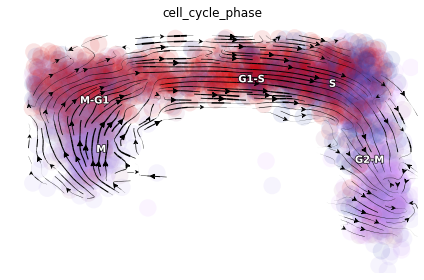

In [5]:
dyn.tl.reduceDimension(rpe1_kinetics_without_spliced_dynamo, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_without_spliced_dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

print("\nDynamo twostep Method; Total velocity")
# plot streamlines
dyn.pl.streamline_plot(rpe1_kinetics_without_spliced_dynamo, color=['cell_cycle_phase'], basis='RFP_GFP')

Select gene DCBLD2 and HIPK2 to check their total velocity:

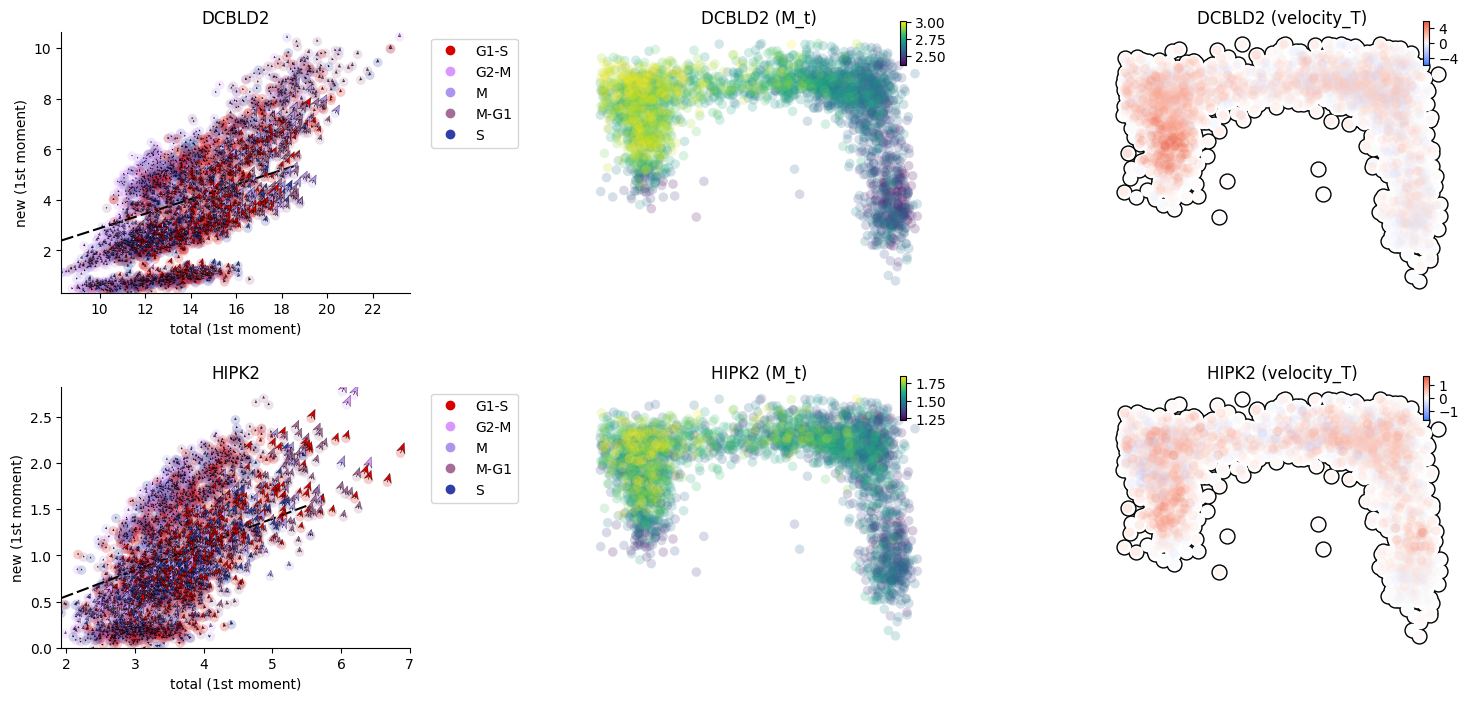

In [6]:
genes = ['DCBLD2', 'HIPK2']
dyn.pl.phase_portraits(rpe1_kinetics_without_spliced_dynamo, genes=genes, color='cell_cycle_phase', basis='RFP_GFP', vkey='velocity_T',
                       ekey='M_t', show_arrowed_spines=False, show_quiver=True, quiver_size=5)

The results show that the velocities calculated by the dynamo twostep method are wrong in the gene HIPK2 and DCBLD2.

Calculate consistency scores and correctness scores for **total** RNA velocity in gene expression space and RFP_GFP space:

In [7]:
# select the genes for restoring dynamics
rpe1_kinetics_without_spliced_dynamo_dynamics = rpe1_kinetics_without_spliced_dynamo[:,rpe1_kinetics_without_spliced_dynamo.var["use_for_transition"]]

# get the total expression and velocity of the original space and the RFP-GFP space.
X_T_expression_space = rpe1_kinetics_without_spliced_dynamo_dynamics.layers['M_t']
V_T_expression_space = rpe1_kinetics_without_spliced_dynamo_dynamics.layers['velocity_T']
X_T_RFP_GFP_space = rpe1_kinetics_without_spliced_dynamo_dynamics.obsm['X_RFP_GFP']
V_T_RFP_GFP_space = rpe1_kinetics_without_spliced_dynamo_dynamics.obsm['velocity_RFP_GFP']

# calculate the correctness and consistency of the velocity
correct_T_expression_dynamo = correct_statistics(X_T_expression_space, V_T_expression_space)
correct_T_RFP_GFP_dynamo = correct_statistics(X_T_RFP_GFP_space, V_T_RFP_GFP_space)
consistency_T_expression_dynamo = consistency_statistics(rpe1_kinetics_without_spliced_dynamo_dynamics, X_T_expression_space, V_T_expression_space)
consistency_T_RFP_GFP_dynamo = consistency_statistics(rpe1_kinetics_without_spliced_dynamo_dynamics, X_T_RFP_GFP_space, V_T_RFP_GFP_space)

del rpe1_kinetics_without_spliced_dynamo, rpe1_kinetics_without_spliced_dynamo_dynamics

calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:15<00:
calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:08<00:


### CSP method 

Set **est_method='CSP4ML_CSP'** to use CSP method:

In [8]:
rpe1_kinetics_without_spliced_csp = rpe1_kinetics_without_spliced.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_without_spliced_csp,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=True,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='CSP4ML_CSP',
                       )

rpe1_kinetics_without_spliced_csp.obsm['X_RFP_GFP'] = rpe1_kinetics_without_spliced_csp.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 653.89it/s]
Infer parameters via maximum likelihood estimation based on the CSP model: 97it [00:00, 473.01it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 653it [00:01, 493.98it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 824it [00:01, 539.70it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 1000it [00:01, 512.44it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [10.8985s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

Visualize **total** RNA velocity streamlines in two dimensions:

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0040s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.2382s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5745s]

CSP Method; Total Velocity


<Figure size 600x400 with 0 Axes>

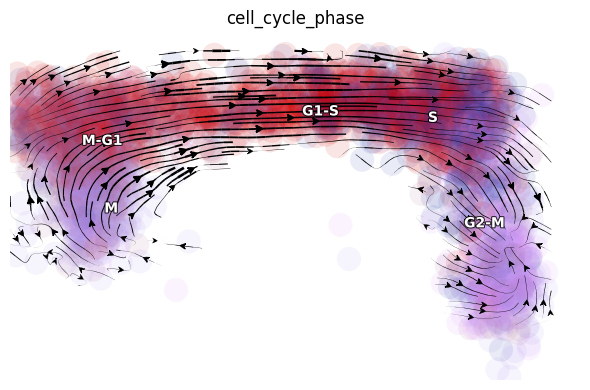

In [9]:
dyn.tl.reduceDimension(rpe1_kinetics_without_spliced_csp, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_without_spliced_csp, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

print("\nCSP Method; Total Velocity")
# plot streamlines
dyn.pl.streamline_plot(rpe1_kinetics_without_spliced_csp, color=['cell_cycle_phase'], basis='RFP_GFP')

Select gene DCBLD2 and HIPK2 to check their total velocity:

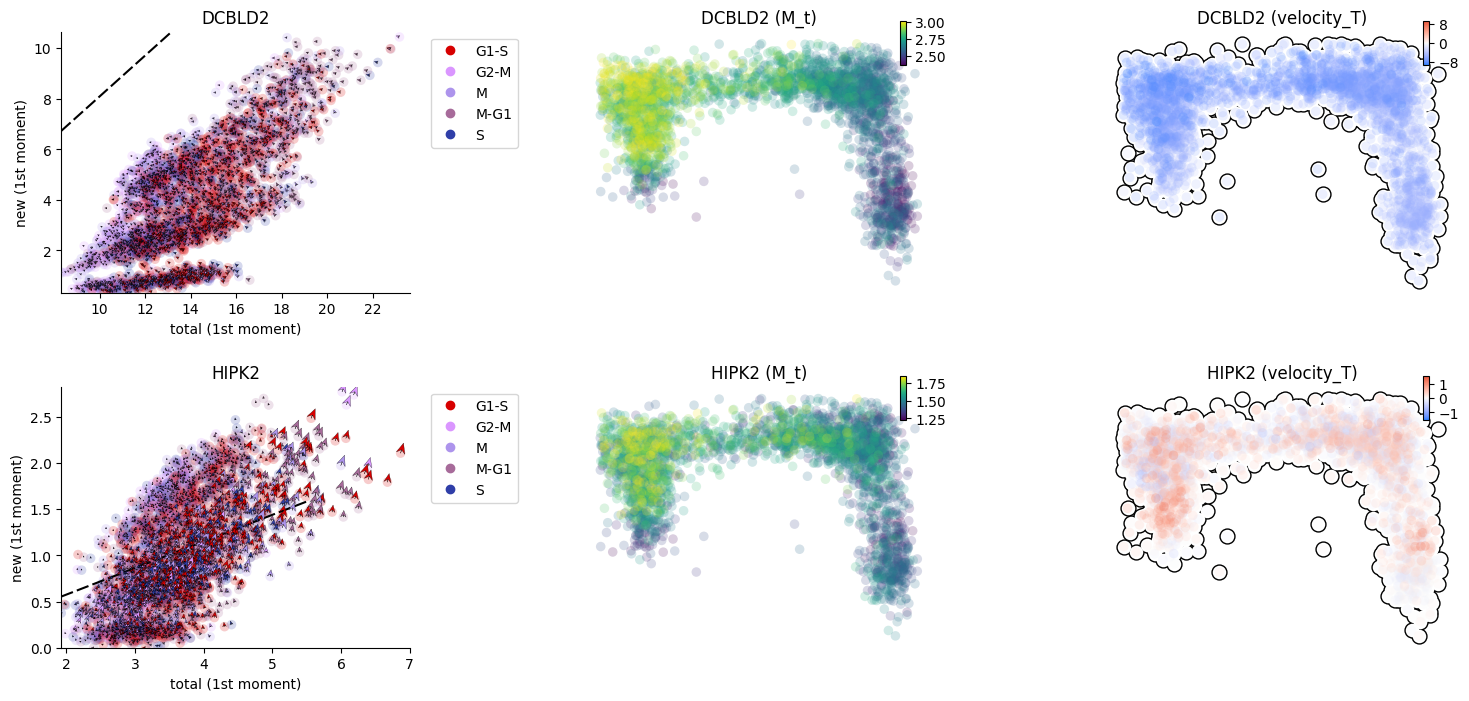

In [10]:
genes = ['DCBLD2', 'HIPK2']
dyn.pl.phase_portraits(rpe1_kinetics_without_spliced_csp, genes=genes, color='cell_cycle_phase', basis='RFP_GFP', vkey='velocity_T',
                       ekey='M_t', show_arrowed_spines=False, show_quiver=True, quiver_size=5)

The results showed that the CSP method correctly calculated the total RNA velocity of the gene DCBLD2, while it was wrong on the gene HIPK2.

Calculate consistency scores and correctness scores for **total** RNA velocity in gene expression space and RFP_GFP space:

In [11]:
# select the genes for restoring dynamics
rpe1_kinetics_without_spliced_csp_dynamics = rpe1_kinetics_without_spliced_csp[:,rpe1_kinetics_without_spliced_csp.var["use_for_transition"]]

# get the total expression and velocity of the original space and the RFP-GFP space.
X_T_expression_space = rpe1_kinetics_without_spliced_csp_dynamics.layers['M_t']
V_T_expression_space = rpe1_kinetics_without_spliced_csp_dynamics.layers['velocity_T']
X_T_RFP_GFP_space = rpe1_kinetics_without_spliced_csp_dynamics.obsm['X_RFP_GFP']
V_T_RFP_GFP_space = rpe1_kinetics_without_spliced_csp_dynamics.obsm['velocity_RFP_GFP']

# calculate the correctness and consistency of the velocity
correct_T_expression_csp = correct_statistics(X_T_expression_space, V_T_expression_space)
correct_T_RFP_GFP_csp = correct_statistics(X_T_RFP_GFP_space, V_T_RFP_GFP_space)
consistency_T_expression_csp = consistency_statistics(rpe1_kinetics_without_spliced_csp_dynamics, X_T_expression_space, V_T_expression_space)
consistency_T_RFP_GFP_csp = consistency_statistics(rpe1_kinetics_without_spliced_csp_dynamics, X_T_RFP_GFP_space, V_T_RFP_GFP_space)

del rpe1_kinetics_without_spliced_csp, rpe1_kinetics_without_spliced_csp_dynamics

calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:16<00:
calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:07<00:


### CSZIP method

Set **est_method='CSP4ML_CSZIP'** to use CSZIP method:

In [12]:
rpe1_kinetics_without_spliced_cszip = rpe1_kinetics_without_spliced.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_without_spliced_cszip,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=True,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='CSP4ML_CSZIP',
                       )

rpe1_kinetics_without_spliced_cszip.obsm['X_RFP_GFP'] = rpe1_kinetics_without_spliced_cszip.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 667.02it/s]
Infer parameters via maximum likelihood estimation based on the CSZIP model: 34it [00:00, 157.70it/s]

Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 365it [00:02, 149.66it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 602it [00:04, 157.28it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 767it [00:05, 152.09it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 817it [00:05, 158.57it/s]

Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 849it [00:05, 148.54it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 1000it [00:06, 149.06it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [11.6036s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

Visualize **total** RNA velocity streamlines in two dimensions:

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0018s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.1659s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5916s]

CSZIP Method; Total Velocity


<Figure size 600x400 with 0 Axes>

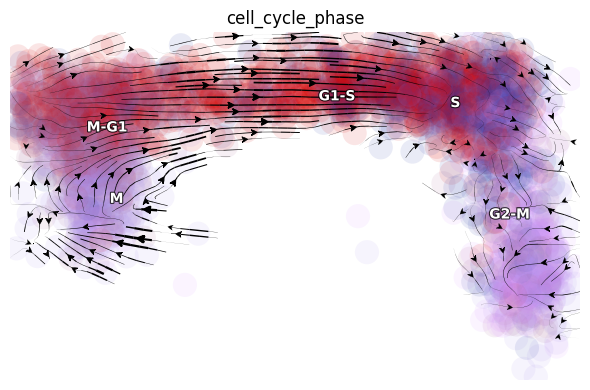

In [13]:
dyn.tl.reduceDimension(rpe1_kinetics_without_spliced_cszip, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_without_spliced_cszip, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

print("\nCSZIP Method; Total Velocity")
# plot streamlines
dyn.pl.streamline_plot(rpe1_kinetics_without_spliced_cszip, color=['cell_cycle_phase'], basis='RFP_GFP')

Select gene DCBLD2 and HIPK2 to check their total velocity:

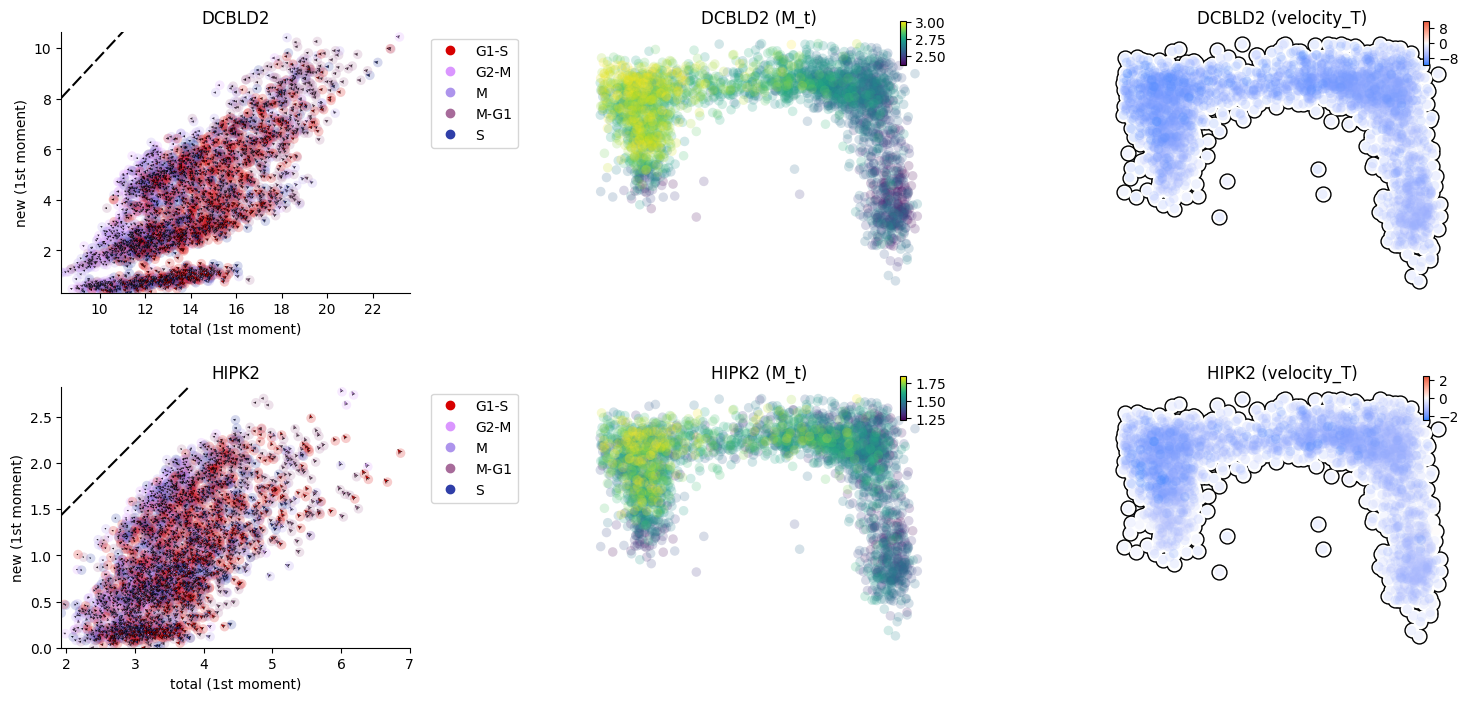

In [14]:
genes = ['DCBLD2', 'HIPK2']
dyn.pl.phase_portraits(rpe1_kinetics_without_spliced_cszip, genes=genes, color='cell_cycle_phase', basis='RFP_GFP', vkey='velocity_T',
                       ekey='M_t', show_arrowed_spines=False, show_quiver=True, quiver_size=5)

The results show that the CSZIP method correctly calculates the direction of the velocity of the two example genes.

Calculate consistency scores and correctness scores for **total** RNA velocity in gene expression space and RFP_GFP space:

In [15]:
# select the genes for restoring dynamics
rpe1_kinetics_without_spliced_cszip_dynamics = rpe1_kinetics_without_spliced_cszip[:,rpe1_kinetics_without_spliced_cszip.var["use_for_transition"]]

# get the total expression and velocity of the original space and the RFP-GFP space.
X_T_expression_space = rpe1_kinetics_without_spliced_cszip_dynamics.layers['M_t']
V_T_expression_space = rpe1_kinetics_without_spliced_cszip_dynamics.layers['velocity_T']
X_T_RFP_GFP_space = rpe1_kinetics_without_spliced_cszip_dynamics.obsm['X_RFP_GFP']
V_T_RFP_GFP_space = rpe1_kinetics_without_spliced_cszip_dynamics.obsm['velocity_RFP_GFP']

# calculate the correctness and consistency of the velocity
correct_T_expression_cszip = correct_statistics(X_T_expression_space, V_T_expression_space)
correct_T_RFP_GFP_cszip = correct_statistics(X_T_RFP_GFP_space, V_T_RFP_GFP_space)
consistency_T_expression_cszip = consistency_statistics(rpe1_kinetics_without_spliced_cszip_dynamics, X_T_expression_space, V_T_expression_space)
consistency_T_RFP_GFP_cszip = consistency_statistics(rpe1_kinetics_without_spliced_cszip_dynamics, X_T_RFP_GFP_space, V_T_RFP_GFP_space)

del rpe1_kinetics_without_spliced_cszip, rpe1_kinetics_without_spliced_cszip_dynamics
del rpe1_kinetics_without_spliced

calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:16<00:
calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:08<00:


##  Spliced and total RNA velocity results based on data with spliced mRNA information

We used dynamo twostep and ICSP to calculate spliced and total RNA velocity and visualize the streamlines in two dimensions, respectively. 

Similar to before, we selected typical genes to see their velocity and compared different methods by consistency scores and correctness scores.

### Dynamo twostep method

Set **est_method='twostep'** to use dynamo twostep method:

In [16]:
rpe1_kinetics_dynamo = rpe1_kinetics.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_dynamo,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=True,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='twostep',
                       )

rpe1_kinetics_dynamo.obsm['X_RFP_GFP'] = rpe1_kinetics_dynamo.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate slope k via linear regression.: 1000it [00:01, 719.09it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 650.32it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [11.0912s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [1.8936s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embeddin

Visualize **spliced** RNA velocity streamlines in two dimensions:

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0015s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [1.8853s]
|-----> [projecting velocity vector to l

<Figure size 600x400 with 0 Axes>

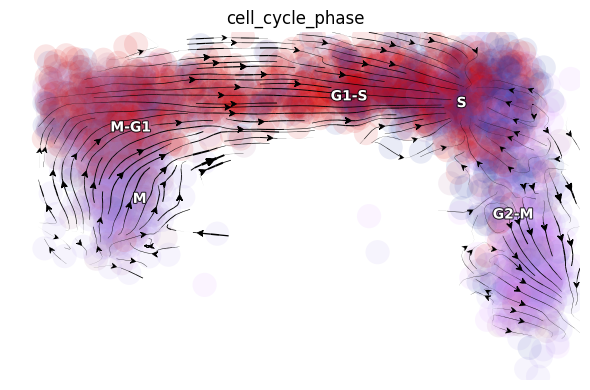

In [17]:
dyn.tl.reduceDimension(rpe1_kinetics_dynamo, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_dynamo, enforce=True, vkey='velocity_S', ekey='M_s', basis='RFP_GFP')

print("\nDynamo twostep Method; Spliced Velocity")
# plot streamlines
dyn.pl.streamline_plot(rpe1_kinetics_dynamo, color=['cell_cycle_phase'], vkey='velocity_S', ekey='M_s', basis='RFP_GFP')

Select gene DCBLD2 and HIPK2 to check their **spliced** velocity:

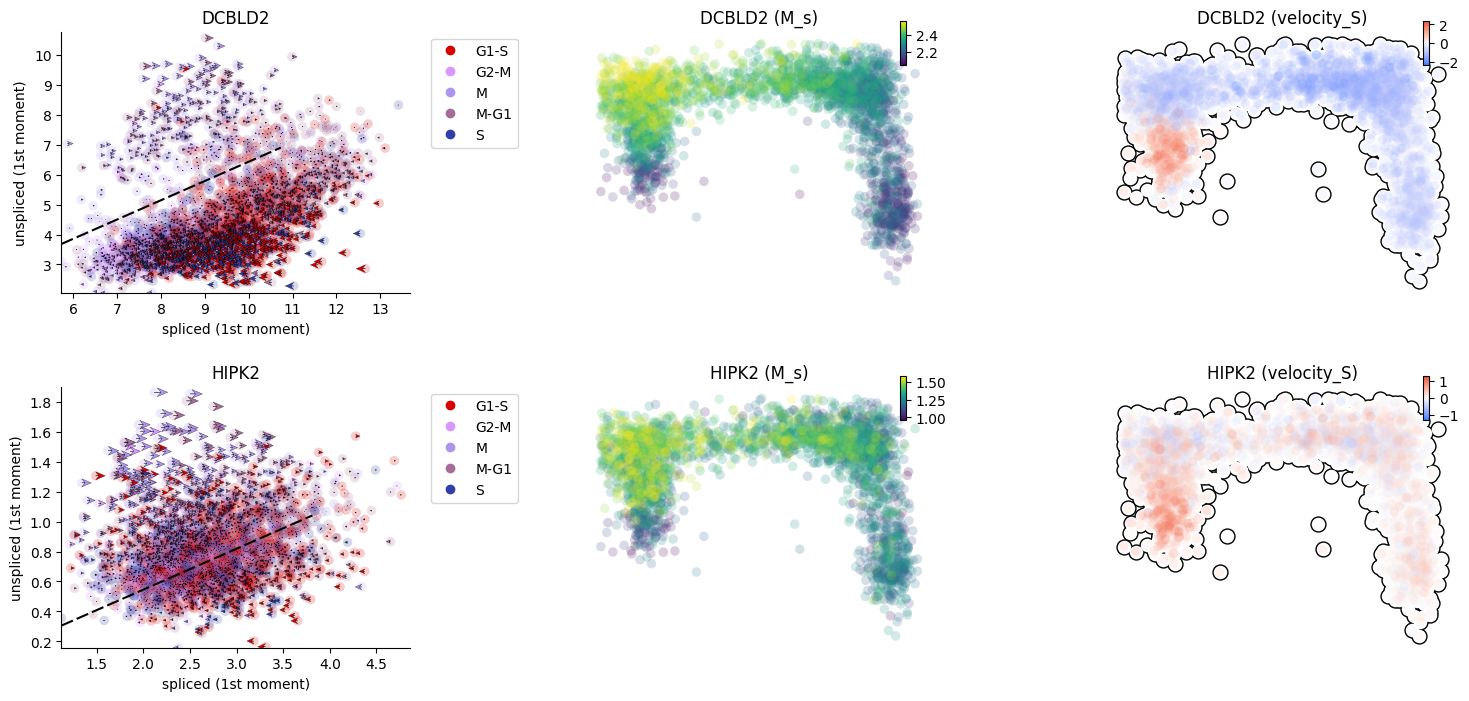

In [18]:
genes = ['DCBLD2', 'HIPK2']
dyn.pl.phase_portraits(rpe1_kinetics_dynamo, genes=genes, color='cell_cycle_phase', basis='RFP_GFP', vkey='velocity_S',
                       ekey='M_s', show_arrowed_spines=False, show_quiver=True, quiver_size=5)

Calculate consistency scores and correctness scores for **spliced** RNA velocity in gene expression space and RFP_GFP space:

In [19]:
# select the genes for restoring dynamics
rpe1_kinetics_dynamo_dynamics = rpe1_kinetics_dynamo[:,rpe1_kinetics_dynamo.var["use_for_transition"]]

# get the spliced expression and velocity of the original space and the RFP-GFP space.
X_S_expression_space = rpe1_kinetics_dynamo_dynamics.layers['M_s']
V_S_expression_space = rpe1_kinetics_dynamo_dynamics.layers['velocity_S']
X_S_RFP_GFP_space = rpe1_kinetics_dynamo_dynamics.obsm['X_RFP_GFP']
V_S_RFP_GFP_space = rpe1_kinetics_dynamo_dynamics.obsm['velocity_RFP_GFP']

# calculate the correctness and consistency of the velocity
correct_S_expression_dynamo = correct_statistics(X_S_expression_space, V_S_expression_space)
correct_S_RFP_GFP_dynamo = correct_statistics(X_S_RFP_GFP_space, V_S_RFP_GFP_space)
consistency_S_expression_dynamo = consistency_statistics(rpe1_kinetics_dynamo_dynamics, X_S_expression_space, V_S_expression_space)
consistency_S_RFP_GFP_dynamo = consistency_statistics(rpe1_kinetics_dynamo_dynamics, X_S_RFP_GFP_space, V_S_RFP_GFP_space)

del rpe1_kinetics_dynamo, rpe1_kinetics_dynamo_dynamics

calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:15<00:
calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:08<00:


### ICSP method

Set **est_method='CSP4ML_ICSP'** to use ICSP method:

In [20]:
rpe1_kinetics_icsp = rpe1_kinetics.copy()
dyn.tl.recipe_kin_data(adata=rpe1_kinetics_icsp,
                       keep_filtered_genes=True,
                       keep_raw_layers=True,
                       del_2nd_moments=True,
                       tkey='time',
                       n_top_genes=1000,
                       est_method='CSP4ML_ICSP',
                       )

rpe1_kinetics_icsp.obsm['X_RFP_GFP'] = rpe1_kinetics_icsp.obs.loc[:,
                                  ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')

|-----> keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: keep_filtered_cells_key=False
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache 

Estimate slope k via linear regression.: 1000it [00:01, 728.26it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 652.37it/s]
Estimate gamma via maximum likelihood estimation based on the ICSP model : 1000it [00:04, 221.67it/s]
Estimate cell specific alpha and beta: 1000it [08:06,  2.05it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [11.0428s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [3.7343s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embeddin

Visualize **total** RNA velocity streamlines in two dimensions:

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0034s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.2759s]
|-----> [projecting velocity vector to l

<Figure size 600x400 with 0 Axes>

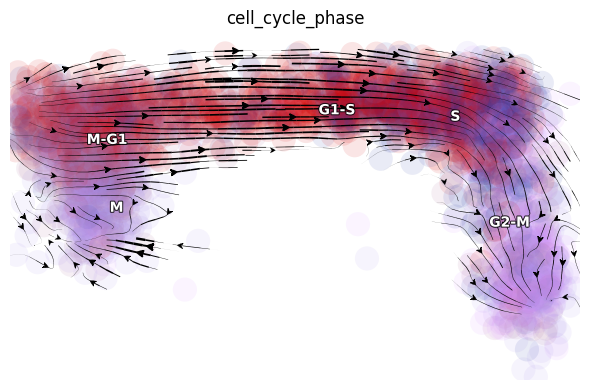

In [21]:
dyn.tl.reduceDimension(rpe1_kinetics_icsp, reduction_method='umap')
dyn.tl.cell_velocities(rpe1_kinetics_icsp, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

print("\nICSP Method; Total Velocity")
# plot streamlines
dyn.pl.streamline_plot(rpe1_kinetics_icsp, color=['cell_cycle_phase'], vkey='velocity_T', ekey='M_t', basis='RFP_GFP')

Select gene DCBLD2 and HIPK2 to check their total velocity:

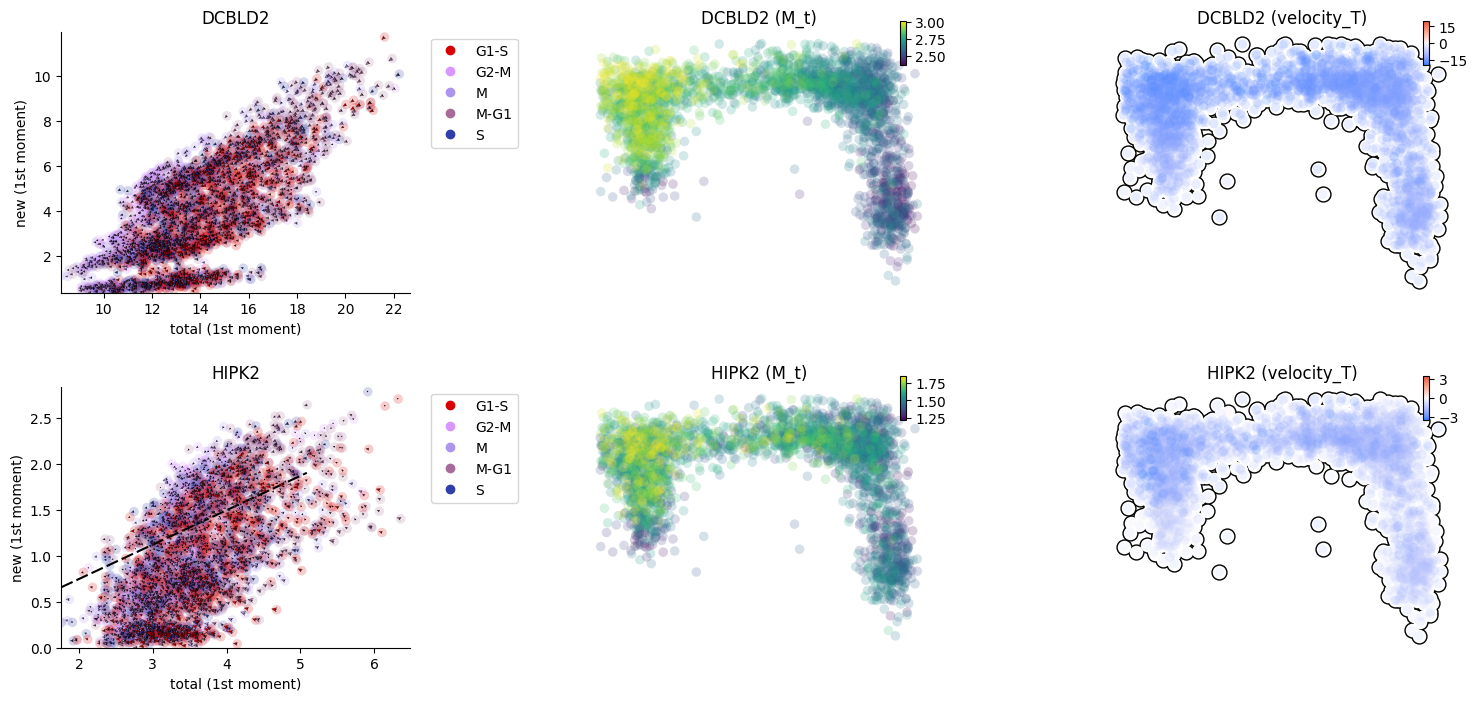

In [22]:
genes = ['DCBLD2', 'HIPK2']
dyn.pl.phase_portraits(rpe1_kinetics_icsp, genes=genes, color='cell_cycle_phase', basis='RFP_GFP', vkey='velocity_T',
                       ekey='M_t', show_arrowed_spines=False, show_quiver=True, quiver_size=5)

Calculate consistency scores and correctness scores for **total** RNA velocity in gene expression space and RFP_GFP space:

In [23]:
# select the genes for restoring dynamics
rpe1_kinetics_icsp_dynamics = rpe1_kinetics_icsp[:,rpe1_kinetics_icsp.var["use_for_transition"]]

# get the total expression and total velocity of the original space and the RFP-GFP space.
X_T_expression_space = rpe1_kinetics_icsp_dynamics.layers['M_t']
V_T_expression_space = rpe1_kinetics_icsp_dynamics.layers['velocity_T']
X_T_RFP_GFP_space = rpe1_kinetics_icsp_dynamics.obsm['X_RFP_GFP']
V_T_RFP_GFP_space = rpe1_kinetics_icsp_dynamics.obsm['velocity_RFP_GFP']

# calculate the correctness and consistency of the velocity
correct_T_expression_icsp = correct_statistics(X_T_expression_space, V_T_expression_space)
correct_T_RFP_GFP_icsp = correct_statistics(X_T_RFP_GFP_space, V_T_RFP_GFP_space)
consistency_T_expression_icsp = consistency_statistics(rpe1_kinetics_icsp_dynamics, X_T_expression_space, V_T_expression_space)
consistency_T_RFP_GFP_icsp = consistency_statistics(rpe1_kinetics_icsp_dynamics, X_T_RFP_GFP_space, V_T_RFP_GFP_space)

calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:16<00:
calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:07<00:


Visualize **spliced** RNA velocity streamlines in two dimensions:

|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.4494s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5615s]

ICSP Method; Spliced Velocity


<Figure size 600x400 with 0 Axes>

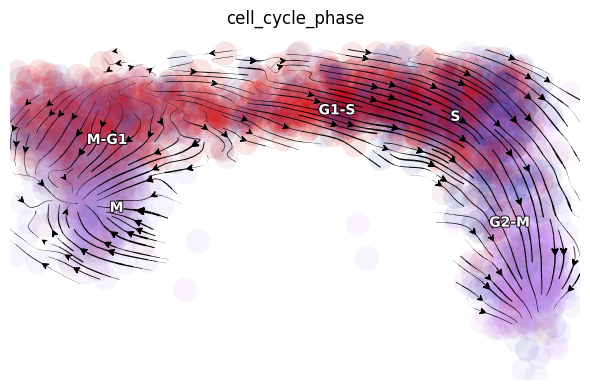

In [24]:
dyn.tl.cell_velocities(rpe1_kinetics_icsp, enforce=True, vkey='velocity_S', ekey='M_s', basis='RFP_GFP')
print("\nICSP Method; Spliced Velocity")
# plot streamlines
dyn.pl.streamline_plot(rpe1_kinetics_icsp, color=['cell_cycle_phase'], vkey='velocity_S', ekey='M_s', basis='RFP_GFP')

Select gene DCBLD2 and HIPK2 to check their spliced velocity:

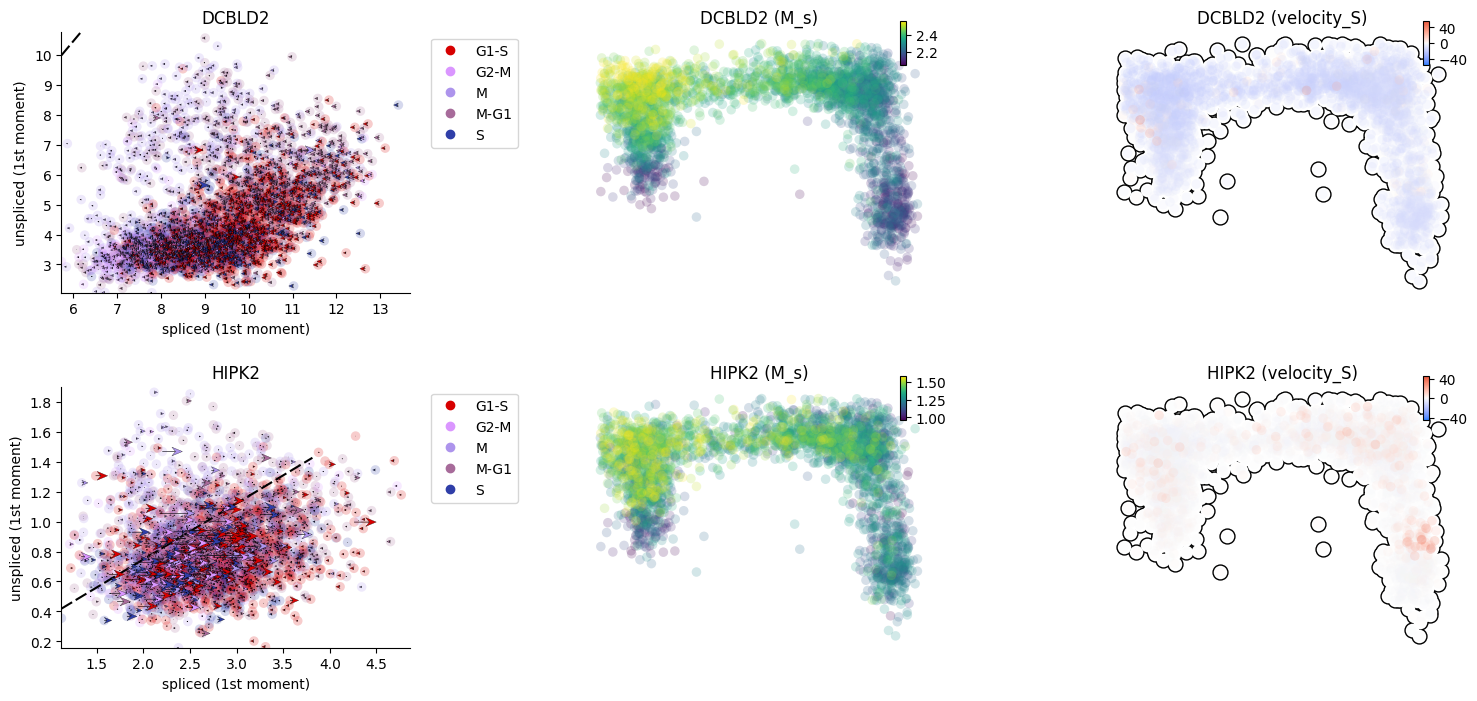

In [25]:
genes = ['DCBLD2', 'HIPK2']
dyn.pl.phase_portraits(rpe1_kinetics_icsp, genes=genes, color='cell_cycle_phase', basis='RFP_GFP', vkey='velocity_S',
                       ekey='M_s', show_arrowed_spines=False, show_quiver=True, quiver_size=5)

Calculate consistency scores and correctness scores for **spliced** RNA velocity in gene expression space and RFP_GFP space:

In [26]:
# select the genes for restoring dynamics
rpe1_kinetics_icsp_dynamics = rpe1_kinetics_icsp[:,rpe1_kinetics_icsp.var["use_for_transition"]]

# get the spliced expression and velocity of the original space and the RFP-GFP space.
X_S_expression_space = rpe1_kinetics_icsp_dynamics.layers['M_s']
V_S_expression_space = rpe1_kinetics_icsp_dynamics.layers['velocity_S']
X_S_RFP_GFP_space = rpe1_kinetics_icsp_dynamics.obsm['X_RFP_GFP']
V_S_RFP_GFP_space = rpe1_kinetics_icsp_dynamics.obsm['velocity_RFP_GFP']

# calculate the correctness and consistency of the velocity
correct_S_expression_icsp = correct_statistics(X_S_expression_space, V_S_expression_space)
correct_S_RFP_GFP_icsp = correct_statistics(X_S_RFP_GFP_space, V_S_RFP_GFP_space)
consistency_S_expression_icsp = consistency_statistics(rpe1_kinetics_icsp_dynamics, X_S_expression_space, V_S_expression_space)
consistency_S_RFP_GFP_icsp = consistency_statistics(rpe1_kinetics_icsp_dynamics, X_S_RFP_GFP_space, V_S_RFP_GFP_space)

del rpe1_kinetics_icsp, rpe1_kinetics_icsp_dynamics

del rpe1_kinetics

calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:16<00:
calculating correlation based cell wise confidence: 100%|█| 2793/2793 [00:07<00:


## Visualize the comparison of the consistency and correctness of results between different methods.

We use box line plots to visualize the consistency scores and correctness scores of total RNA velocity in gene expression space and RFP_GFP space compared across dynamo twostep, CSP, CSZIP and ICSP methods, and spliced RNA velocity compared across dynamo twostep and ICSP methods. In addition, we used the one-sided Wilcoxon test to quantitatively illustrate the superiority of CSP4ML compared to dynamo twostep.

Change the matplotlib settings for better visualization:

In [27]:
import matplotlib.pyplot as plt
import scanpy as sc
figsize = (1.4625, 1.4625 * 0.92 / 1.25)
dpi = 150
fliersize = 2.5
sc.set_figure_params(scanpy=True, fontsize=6)

### Gene expression space

#### Compare the correctness of the total velocity:

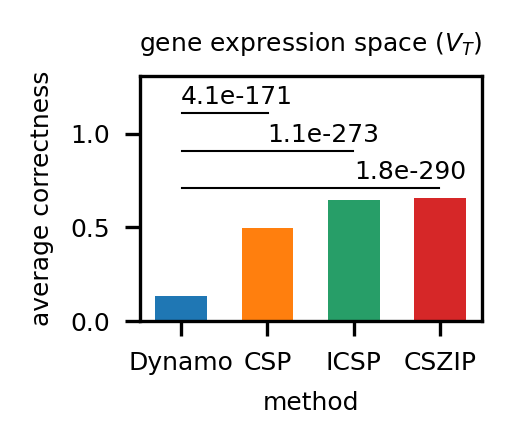

In [28]:
# one-sided wilcoxon test
_, p_value_CSP = wilcoxon(correct_T_expression_csp, correct_T_expression_dynamo, alternative='greater')
_, p_value_ICSP = wilcoxon(correct_T_expression_icsp, correct_T_expression_dynamo, alternative='greater')
_, p_value_CSZIP = wilcoxon(correct_T_expression_cszip, correct_T_expression_dynamo, alternative='greater')

# bar plot
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
groups = 4
method = ['Dynamo', 'CSP', 'ICSP', 'CSZIP']
ind = np.linspace(0, groups, groups)
x_label = 'method'
y_label = 'average correctness'
ax.set_xticks(ind)
ax.set_xticklabels(method)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)

data = [np.mean(correct_T_expression_dynamo), np.mean(correct_T_expression_csp), 
        np.mean(correct_T_expression_icsp), np.mean(correct_T_expression_cszip)]
ax.bar(ind[0], data[0])
ax.bar(ind[1], data[1])
ax.bar(ind[2], data[2])
ax.bar(ind[3], data[3])

# add p_value
per_len = 1 / groups
y_start = max(data) + 0.05
y_intervel = 0.2
plt.axhline(y=y_start+2*y_intervel, xmin=per_len / 2, xmax=per_len / 2 + per_len, color="black", linewidth=0.5)
plt.axhline(y=y_start+y_intervel, xmin=per_len / 2, xmax=per_len / 2 + 2 * per_len, color="black", linewidth=0.5)
plt.axhline(y=y_start, xmin=per_len / 2, xmax=per_len / 2 + 3 * per_len, color="black", linewidth=0.5)
plt.text(ind[0], y_start+2*y_intervel+0.05, format(p_value_CSP, '.1e'))
plt.text(ind[1], y_start+y_intervel+0.05, format(p_value_ICSP, '.1e'))
plt.text(ind[2], y_start+0.05, format(p_value_CSZIP, '.1e'))
plt.ylim(ymax=y_start+y_intervel*3)

plt.title('gene expression space ($V_{T}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/corr_total_raw.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

In the expression space of genes used to construct the transfer matrix (different methods select genes according to their respective goodness of fit), the results show that our three stochastic model-based methods compute a total velocity significantly better than the dynamo twostep method in terms of correctness.

#### Compare the correctness of the spliced velocity:

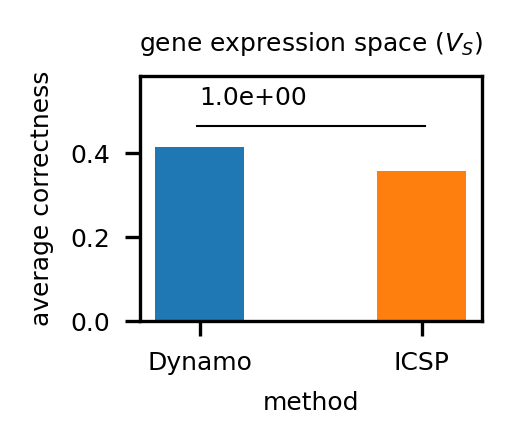

In [29]:
# one-sided wilcoxon test
_, p_value_ICSP = wilcoxon(correct_S_expression_icsp, correct_S_expression_dynamo, alternative='greater')

# bar plot
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
groups = 2
method = ['Dynamo', 'ICSP']
ind = np.linspace(0, groups, groups)
x_label = 'method'
y_label = 'average correctness'
ax.set_xticks(ind)
ax.set_xticklabels(method)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)

data = [np.mean(correct_S_expression_dynamo), np.mean(correct_S_expression_icsp)]
ax.bar(ind[0], data[0])
ax.bar(ind[1], data[1])

# add p_value
per_len = 1 / 3
y_start = max(data) + 0.05
y_intervel = 0.12

plt.axhline(y=y_start, xmin=per_len / 2, xmax=per_len / 2 + 2*per_len, color="black", linewidth=0.5)
plt.text(ind[0], y_start+0.05, format(p_value_ICSP, '.1e'))
plt.ylim(ymax=y_start+y_intervel*1)

plt.title('gene expression space ($V_{S}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/corr_spliced_raw.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The results show that the spliced velocity calculated by the dynamo method is superior to that of the ICSP method in terms of correctness.

#### Compare the consistency of the total velocity:

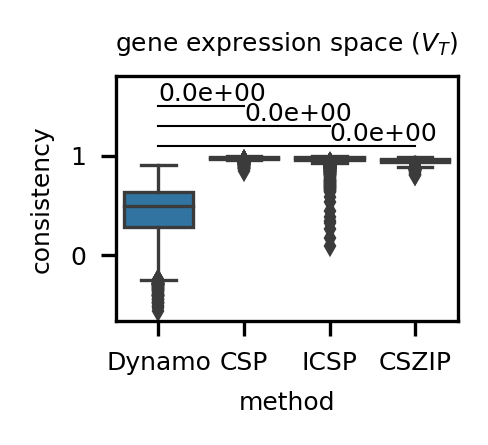

In [30]:
# one-sided wilcoxon test
_, p_value_CSP = wilcoxon(consistency_T_expression_csp, consistency_T_expression_dynamo, alternative='greater')
_, p_value_ICSP = wilcoxon(consistency_T_expression_icsp, consistency_T_expression_dynamo, alternative='greater')
_, p_value_CSZIP = wilcoxon(consistency_T_expression_cszip, consistency_T_expression_dynamo, alternative='greater')

# box plot
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
x_label = 'method'
y_label = 'consistency'
data = pd.DataFrame(np.array(
    [consistency_T_expression_dynamo, consistency_T_expression_csp, consistency_T_expression_icsp, consistency_T_expression_cszip]).T,
                    columns=['Dynamo', 'CSP', 'ICSP', 'CSZIP'])
order = ['Dynamo', 'CSP', 'ICSP', 'CSZIP']
sns.boxplot(data=data, order=order, ax=ax, fliersize=fliersize, linewidth=0.8)

# add p_value
per_len = 1 / len(order)
plt.axhline(y=1.5, xmin=per_len / 2, xmax=per_len / 2 + per_len, color="black", linewidth=0.5)
plt.axhline(y=1.3, xmin=per_len / 2, xmax=per_len / 2 + 2 * per_len, color="black", linewidth=0.5)
plt.axhline(y=1.1, xmin=per_len / 2, xmax=per_len / 2 + 3 * per_len, color="black", linewidth=0.5)
plt.text(0, 1.55, format(p_value_CSP, '.1e'))
plt.text(1, 1.35, format(p_value_ICSP, '.1e'))
plt.text(2, 1.15, format(p_value_CSZIP, '.1e'))
plt.ylim(ymax=1.8)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title('gene expression space ($V_{T}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/cons_total_raw.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The results show that the consistency of total RNA velocity of our three stochastic model-based methods is also better than that of the dynamo twostep method in gene expression space.

#### Compare the consistency of the spliced velocity:

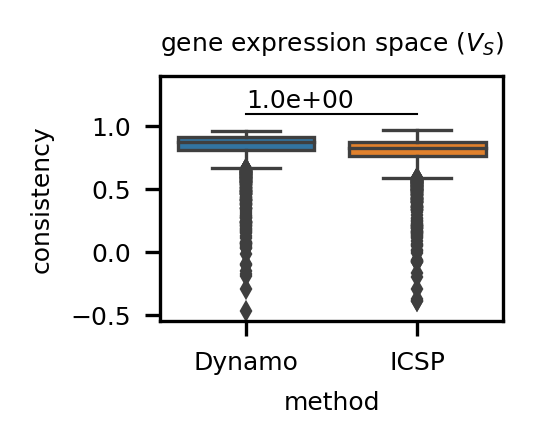

In [31]:
# one-sided wilcoxon test
_, p_value_ICSP = wilcoxon(consistency_S_expression_icsp, consistency_S_expression_dynamo, alternative='greater')

# box plot
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
x_label = 'method'
y_label = 'consistency'
data = pd.DataFrame(np.array([consistency_S_expression_dynamo, consistency_S_expression_icsp]).T,
                    columns=['Dynamo', 'ICSP'])
order = ['Dynamo', 'ICSP']
sns.boxplot(data=data, order=order, ax=ax, fliersize=fliersize, linewidth=0.8)

# add p_value
per_len = 1 / len(order)
plt.axhline(y=1.1, xmin=per_len / 2, xmax=per_len / 2 + per_len, color="black", linewidth=0.5)
plt.text(0, 1.15, format(p_value_ICSP, '.1e'))
plt.ylim(ymax=1.4)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title('gene expression space ($V_{S}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/cons_spliced_raw.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The results show that the consistency of spliced RNA velocity is comparable in gene expression space.

### RFP_GFP space

#### Compare the correctness of the total velocity:

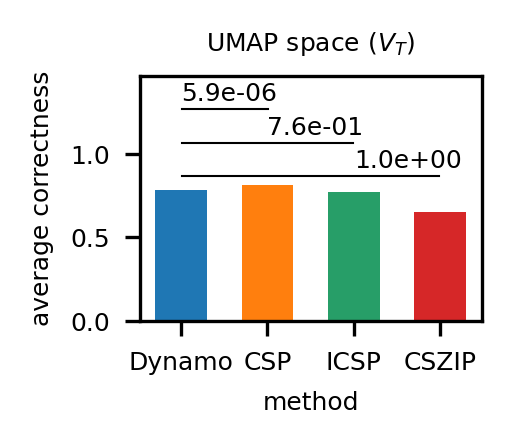

In [32]:
# one-sided wilcoxon test
_, p_value_CSP = wilcoxon(correct_T_RFP_GFP_csp, correct_T_RFP_GFP_dynamo, alternative='greater')
_, p_value_ICSP = wilcoxon(correct_T_RFP_GFP_icsp, correct_T_RFP_GFP_dynamo, alternative='greater')
_, p_value_CSZIP = wilcoxon(correct_T_RFP_GFP_cszip, correct_T_RFP_GFP_dynamo, alternative='greater')

fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
groups = 4
method = ['Dynamo', 'CSP', 'ICSP', 'CSZIP']
ind = np.linspace(0, groups, groups)
x_label = 'method'
y_label = 'average correctness'
ax.set_xticks(ind)
ax.set_xticklabels(method)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)

data = [np.mean(correct_T_RFP_GFP_dynamo), np.mean(correct_T_RFP_GFP_csp), np.mean(correct_T_RFP_GFP_icsp), np.mean(correct_T_RFP_GFP_cszip)]
ax.bar(ind[0], data[0])
ax.bar(ind[1], data[1])
ax.bar(ind[2], data[2])
ax.bar(ind[3], data[3])

# add p_value
per_len = 1 / groups
y_start = max(data) + 0.05
y_intervel = 0.2
plt.axhline(y=y_start+2*y_intervel, xmin=per_len / 2, xmax=per_len / 2 + per_len, color="black", linewidth=0.5)
plt.axhline(y=y_start+y_intervel, xmin=per_len / 2, xmax=per_len / 2 + 2 * per_len, color="black", linewidth=0.5)
plt.axhline(y=y_start, xmin=per_len / 2, xmax=per_len / 2 + 3 * per_len, color="black", linewidth=0.5)
plt.text(ind[0], y_start+2*y_intervel+0.05, format(p_value_CSP, '.1e'))
plt.text(ind[1], y_start+y_intervel+0.05, format(p_value_ICSP, '.1e'))
plt.text(ind[2], y_start+0.05, format(p_value_CSZIP, '.1e'))
plt.ylim(ymax=y_start+y_intervel*3)

plt.title('UMAP space ($V_{T}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/corr_total_umap.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The results show that the total RNA velocity of the CSP method is still significantly better than the dynamo twostep method in the RFP_GFP space.

#### Compare the correctness of the spliced velocity:

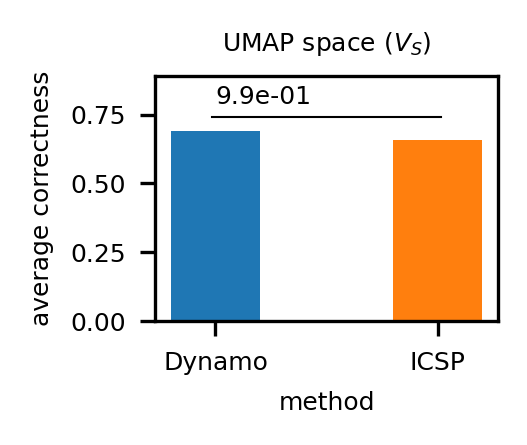

In [33]:
# one-sided wilcoxon test
_, p_value_ICSP = wilcoxon(correct_S_RFP_GFP_icsp, correct_S_RFP_GFP_dynamo, alternative='greater')

# bar plot
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
groups = 2
method = ['Dynamo', 'ICSP']
ind = np.linspace(0, groups, groups)
x_label = 'method'
y_label = 'average correctness'
ax.set_xticks(ind)
ax.set_xticklabels(method)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)

data = [np.mean(correct_S_RFP_GFP_dynamo), np.mean(correct_S_RFP_GFP_icsp)]
ax.bar(ind[0], data[0])
ax.bar(ind[1], data[1])

# add p_value
per_len = 1 / 3
y_start = max(data) + 0.05
y_intervel = 0.15

plt.axhline(y=y_start, xmin=per_len / 2, xmax=per_len / 2 + 2 * per_len, color="black", linewidth=0.5)
plt.text(ind[0], y_start+0.05, format(p_value_ICSP, '.1e'))
plt.ylim(ymax=y_start+y_intervel*1)

plt.title('UMAP space ($V_{S}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/corr_spliced_umap.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The correctness of the spliced RNA velocity is comparable for both methods in RFP_GFP space.

#### Compare the consistency of the total velocity:

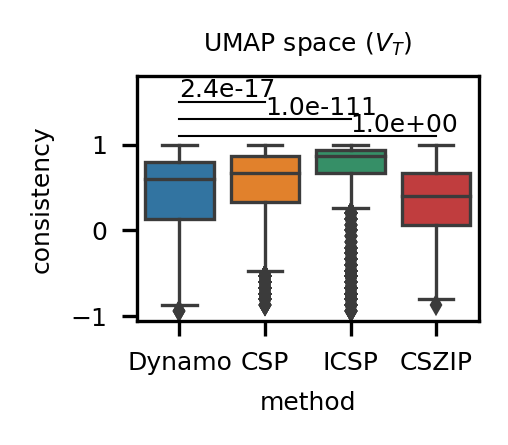

In [34]:
# one-sided wilcoxon test
_, p_value_CSP = wilcoxon(consistency_T_RFP_GFP_csp, consistency_T_RFP_GFP_dynamo, alternative='greater')
_, p_value_ICSP = wilcoxon(consistency_T_RFP_GFP_icsp, consistency_T_RFP_GFP_dynamo, alternative='greater')
_, p_value_CSZIP = wilcoxon(consistency_T_RFP_GFP_cszip, consistency_T_RFP_GFP_dynamo, alternative='greater')

# box plot
fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
x_label = 'method'
y_label = 'consistency'
data = pd.DataFrame(
    np.array(
        [consistency_T_RFP_GFP_dynamo, consistency_T_RFP_GFP_csp, consistency_T_RFP_GFP_icsp,
         consistency_T_RFP_GFP_cszip]).T,
    columns=['Dynamo', 'CSP', 'ICSP', 'CSZIP'])
order = ['Dynamo', 'CSP', 'ICSP', 'CSZIP']
sns.boxplot(data=data, order=order, ax=ax, fliersize=fliersize, linewidth=0.8)

# add p_value
per_len = 1 / len(order)
plt.axhline(y=1.5, xmin=per_len / 2, xmax=per_len / 2 + per_len, color="black", linewidth=0.5)
plt.axhline(y=1.3, xmin=per_len / 2, xmax=per_len / 2 + 2 * per_len, color="black", linewidth=0.5)
plt.axhline(y=1.1, xmin=per_len / 2, xmax=per_len / 2 + 3 * per_len, color="black", linewidth=0.5)
plt.text(0, 1.55, format(p_value_CSP, '.1e'))
plt.text(1, 1.35, format(p_value_ICSP, '.1e'))
plt.text(2, 1.15, format(p_value_CSZIP, '.1e'))
plt.ylim(ymax=1.8)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title('UMAP space ($V_{T}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/cons_total_umap.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The consistency of the total RNA velocity of the CSP and ICSP methods was also significantly better than that of the dynamo twostep method in the RFP_GFP space.

#### Compare the consistency of the spliced velocity:

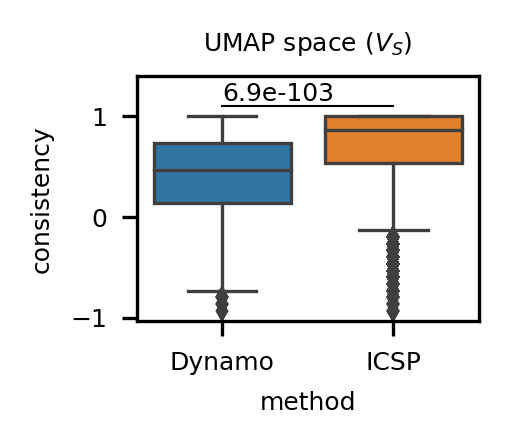

In [35]:
# one-sided wilcoxon test
_, p_value_ICSP = wilcoxon(consistency_S_RFP_GFP_icsp, consistency_S_RFP_GFP_dynamo, alternative='greater')

# box plot
fig = plt.figure(4, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
x_label = 'method'
y_label = 'consistency'
data = pd.DataFrame(np.array([consistency_S_RFP_GFP_dynamo, consistency_S_RFP_GFP_icsp]).T,
                    columns=['Dynamo', 'ICSP'])
order = ['Dynamo', 'ICSP']
sns.boxplot(data=data, order=order, ax=ax, fliersize=fliersize, linewidth=0.8)

# add p_value
per_len = 1 / len(order)
plt.axhline(y=1.1, xmin=per_len / 2, xmax=per_len / 2 + per_len, color="black", linewidth=0.5)
plt.text(0, 1.15, format(p_value_ICSP, '.1e'))
plt.ylim(ymax=1.4)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title('UMAP space ($V_{S}$)')
plt.grid(False)
# plt.savefig('./Figures/dataset1/Velocity/cons_spliced_umap.pdf', dpi=150, ftransparent=True, bbox_inches="tight")
plt.show()

The consistency of the spliced RNA velocity of the ICSP method was also significantly better than that of the dynamo twostep method in the RFP_GFP space.